<a href="https://colab.research.google.com/github/k-dinakaran/AI-powered-prompt-to-3D-image-generator/blob/main/prompt_to_3D_image_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers transformers accelerate torch safetensors imageio

In [ ]:
import os
os.environ['SPCONV_ALGO'] = 'native'  # Use 'native' for faster execution

In [ ]:
!pip install torch torchvision torchaudio
!pip install diffusers transformers accelerate safetensors imageio
!pip install trimesh open3d
!pip install xformers  # Optional, for faster attention mechanisms

INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 44.2 MB/s eta 0:00:00
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.5.1+cu124
    Uninstalling torchaudio-2.5.1+cu124:
      Successfully uninstalled torchaudio-2.5.1+cu124


In [ ]:
!git clone https://github.com/Microsoft/TRELLIS.git

fatal: destination path 'TRELLIS' already exists and is not an empty directory.


In [ ]:
%cd TRELLIS

/content/TRELLIS


In [ ]:
!pip uninstall torch torchvision transformers -y
!pip install torch torchvision transformers --upgrade

Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Found existing installation: torchvision 0.21.0
Uninstalling torchvision-0.21.0:
  Successfully uninstalled torchvision-0.21.0
Found existing installation: transformers 4.49.0
Uninstalling transformers-4.49.0:
  Successfully uninstalled transformers-4.49.0
  Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl (766.7 MB)
Using cached torchvision-0.21.0-cp311-cp311-manylinux1_x86_64.whl (7.2 MB)
Using cached transformers-4.49.0-py3-none-any.whl (10.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.18 requires t

In [ ]:
!pip install rembg

In [ ]:
!pip install onnxruntime-gpu

In [ ]:
!pip install plyfile

In [ ]:
!pip install utils3d

In [ ]:
!ls trellis/representations/mesh/flexicubes

__init__.py  __pycache__


In [ ]:
!ls trellis/representations/mesh/flexicubes/__init__.py

trellis/representations/mesh/flexicubes/__init__.py


In [ ]:
!ls trellis/representations/mesh/flexicubes
!cat trellis/representations/mesh/flexicubes/flexicubes.py

__init__.py  __pycache__
cat: trellis/representations/mesh/flexicubes/flexicubes.py: No such file or directory


In [ ]:
class FlexiCubes:
    def __init__(self):
        pass

    def generate_mesh(self, vertices, faces):
        return {'vertices': vertices, 'faces': faces}

In [ ]:
!echo -e "class FlexiCubes:\n    def __init__(self):\n        pass\n\n    def generate_mesh(self, vertices, faces):\n        return {'vertices': vertices, 'faces': faces}" > trellis/representations/mesh/flexicubes/flexicubes.py


In [ ]:
!cat trellis/representations/mesh/flexicubes/flexicubes.py

class FlexiCubes:
    def __init__(self):
        pass

    def generate_mesh(self, vertices, faces):
        return {'vertices': vertices, 'faces': faces}


In [ ]:
# Import the FlexiCubes class
from trellis.representations.mesh.flexicubes import FlexiCubes

# Initialize the FlexiCubes object
flexicubes = FlexiCubes()

# Define vertices and faces for a simple mesh
vertices = [[0, 0, 0], [1, 0, 0], [0, 1, 0]]
faces = [[0, 1, 2]]

# Generate the mesh
mesh = flexicubes.generate_mesh(vertices, faces)

# Print the mesh
print("Generated Mesh:", mesh)

[SPARSE] Backend: spconv, Attention: flash_attn
Generated Mesh: {'vertices': [[0, 0, 0], [1, 0, 0], [0, 1, 0]], 'faces': [[0, 1, 2]]}


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

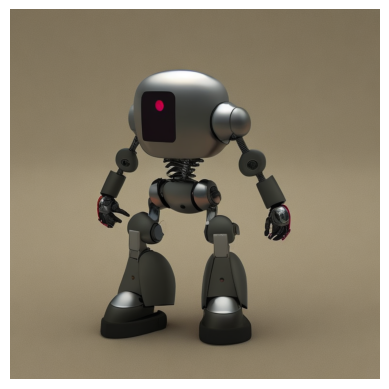

3D model saved as output_3d_model.glb


In [ ]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
from trellis.representations.mesh.flexicubes import FlexiCubes
import trimesh

# Step 1: Generate image from text
model_id = "stabilityai/stable-diffusion-2"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.to("cuda")

prompt = "high quality 3D illustration of a robot"
image = pipe(prompt).images[0]
image.save("generated_image.png")

# Display the image
plt.imshow(image)
plt.axis("off")
plt.show()

# Step 2: Convert image to 3D using FlexiCubes
flexicubes = FlexiCubes()

# Example vertices and faces (replace with actual image-to-3D logic)
vertices = [[0, 0, 0], [1, 0, 0], [0, 1, 0]]
faces = [[0, 1, 2]]

# Generate the mesh
mesh_data = flexicubes.generate_mesh(vertices, faces)

# Convert the mesh data to a trimesh object
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

# Step 3: Export the 3D mesh as a GLB file
mesh.export("output_3d_model.glb")
print("3D model saved as output_3d_model.glb")